In [1]:
import numpy as np
import pprint
import mne
import pyxdf
import matplotlib.pyplot as plt
from pathlib import Path

from scipy import signal

import util.preprocess_util as preprocess
import util.analysis_util as analysis
import util.visualise_util as visualise
from util.data_util import EEG_Dataset, get_trials, get_good_trials
from models.lda import *

%load_ext autoreload
%autoreload 2

# Load data from xdf file

From the Unicorn Stream
- `eeg_data`: the 8 channel raw eeg data
- `eeg_timestamps`: timestamp for each eeg sample
- `fs`: the sampling frequency

From the Open Vibe Marker Stream
- `event_codes`: array of codes sent to the marker stream at the start of each event 
- `event_time_stamps`: array of timestamps signifying the start of each event


In [2]:
DATA_DIR = Path('./data')
DATA_FILE_NAME = 'Sandra_MI_1h.xdf'
DATA_FILE = DATA_DIR / DATA_FILE_NAME

dataset = EEG_Dataset(DATA_FILE)

Data succesfullly loaded from data/Sandra_MI_1h.xdf


In [49]:
# Extract the EEG data
eeg_data = dataset.eeg_data
eeg_timestamps = dataset.eeg_timestamps
fs = dataset.fs

print(f"EEG data shape: {eeg_data.shape}")
print(f'Sampling Frequency: {fs}')

# Extract the marker stream data
event_codes = dataset.event_codes
event_labels = dataset.event_labels
label2code = dataset.label2code
label2code['idle'] = 8
label2code['mi'] = 9
print(f'Total number of events: {event_codes.shape[0]}')
pprint.pprint(f'Label->Code: \n{label2code}')
print(f'Event code for left MI: {label2code["imagery_handL"]}')
print(f'Event code for right MI: {label2code["imagery_handR"]}')
print(f'Count left MI events: {np.sum(event_codes == label2code["imagery_handL"])}')
print(f'Count right MI events: {np.sum(event_codes == label2code["imagery_handR"])}')

EEG data shape: (8, 1023780)
Sampling Frequency: 250
Total number of events: 1213
('Label->Code: \n'
 "{'beep': 0, 'cue_no_blink': 1, 'imagery_no_blink': 2, 'break': 3, "
 "'cue_handR': 4, 'imagery_handR': 5, 'cue_handL': 6, 'imagery_handL': 7, "
 "'idle': 8, 'mi': 9}")
Event code for left MI: 7
Event code for right MI: 5
Count left MI events: 200
Count right MI events: 200


# Build an event time-series/stream

Create a time series from the event codes which is the same length as the EEG data

In [4]:
eeg_timestamps, event_timestamps, event_timeseries = dataset.build_event_timeseries()

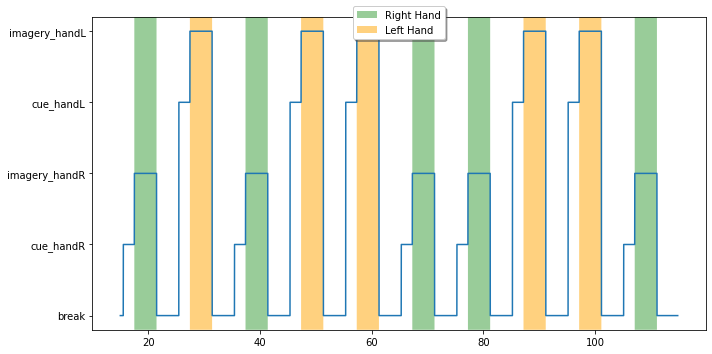

In [5]:
visualise.plot_events(
    eeg_timestamps,
    event_timeseries,
    fs,
    label2code
)

# Preprocess EEG data

## 1. Rereference the EEG data

In [6]:
# Rereference according to the mean
eeg_data = eeg_data - np.mean(eeg_data, axis=0)

## 2. Filter EEG data

In [7]:
lf = 8
hf = 16
nf = 50

# Design notch filter
b, a = signal.iirnotch(w0=nf, Q=7, fs=fs)
freq, h = signal.freqz(b, a, fs = fs)

# Apply notch and bandpass filters
eeg_notched = signal.filtfilt(b, a, eeg_data, axis=1)
eeg_notched_bp = preprocess.bandpass(eeg_notched, lf=lf, hf=hf, fs=fs, ftype='butter')

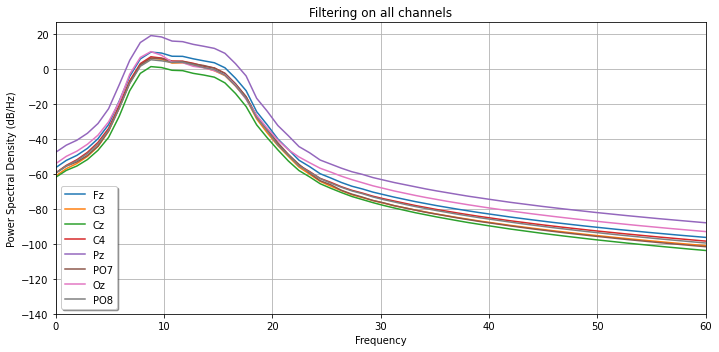

In [8]:
plt.figure(figsize=(10,5))
plt.title(f'Filtering on all channels')

for i in range(eeg_data.shape[0]):
    plt.psd(eeg_notched_bp[i], Fs=fs, label=f'{preprocess.channel2name(i)}')

plt.tight_layout()
plt.legend(loc='lower left', shadow=True)
plt.xlim([0,60])
plt.show()

## 3. Normalise EEG data

In [9]:
eeg_notched_bp_norm = preprocess.normalise_eeg(eeg_notched_bp)

# Split into trials

In [11]:
EEG = eeg_notched_bp_norm.copy()
event_onsets = event_timestamps.copy()
classes = ['imagery_handL', 'imagery_handR', 'cue_handL', 'cue_handR']
class_codes = [label2code[code] for code in classes]
nclasses = len(classes)
nchannels = EEG.shape[0]

# Print some information
print('Sample rate:', fs)
print('Number of EEG channels:', nchannels)
print('Channel names:', [preprocess.channel2name(channel) for channel in range(EEG.shape[0])])

print('\nNumber of classes:', nclasses)
print('Class labels:', classes)

print('\nNumber of events:', len(event_onsets))
print('All event codes:', np.unique(event_codes))
print('Class codes:', class_codes)

Sample rate: 250
Number of EEG channels: 8
Channel names: ['Fz', 'C3', 'Cz', 'C4', 'Pz', 'PO7', 'Oz', 'PO8']

Number of classes: 4
Class labels: ['imagery_handL', 'imagery_handR', 'cue_handL', 'cue_handR']

Number of events: 1213
All event codes: [0 1 2 3 4 5 6 7]
Class codes: [7, 5, 6, 4]


In [12]:
mi_window = [0.5, 2.5]
mi_nsamples = len(np.arange(int(mi_window[0]*fs), int(mi_window[1]*fs)))

idle_window = [0.25, 1.75]
idle_nsamples = len(np.arange(int(idle_window[0]*fs), int(idle_window[1]*fs)))

class_nsamples = [mi_nsamples, mi_nsamples, idle_nsamples, idle_nsamples]

trials = get_trials(
    eeg_data=EEG,
    event_time_series=event_timeseries,
    class_labels=classes,
    label2code=label2code,
    nsamples=class_nsamples
)

for key, val in trials.items():
    print(f'{key}: {val.shape}')

imagery_handL: (8, 500, 200)
imagery_handR: (8, 500, 200)
cue_handL: (8, 375, 200)
cue_handR: (8, 375, 200)


# Some statistical Analysis to remove noisy trials

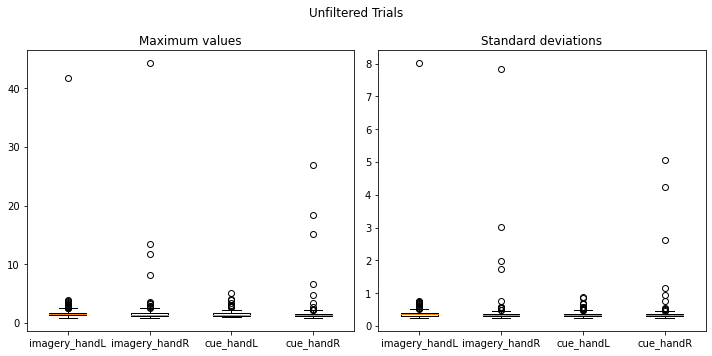

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Unfiltered Trials')

axs[0].set_title('Maximum values')
axs[0].boxplot([ trials[cl].max(axis = (0,1)) for cl in classes ], labels=classes)

axs[1].set_title('Standard deviations')
axs[1].boxplot([ trials[cl].std(axis = (0,1)) for cl in classes ], labels=classes)

plt.tight_layout()
plt.show()

In [14]:
# Set the upper limit on the maxval and std dev as 2*(3rd quartile)

upperlimit_max = {}
for cl in classes:
    upperlimit_max[cl] = np.percentile(trials[cl].max(axis = (0,1)), [75])[0] * 1.5

upperlimit_std = {}
for cl in classes:
    upperlimit_std[cl] = np.percentile(trials[cl].std(axis = (0,1)), [75])[0] * 1.5

upperlimit_std

{'imagery_handL': 0.5966861295360828,
 'imagery_handR': 0.5607748092425172,
 'cue_handL': 0.5647089798842686,
 'cue_handR': 0.5537755257558372}

In [15]:
good_trials = get_good_trials(
    trials=trials,
    nchannels=nchannels,
    class_nsamples=class_nsamples,
    upperlimit_std=upperlimit_std,
    upperlimit_max=upperlimit_max
)

for cl in classes:
    print(f'{cl} has {good_trials[cl].shape} non noisy trials')


imagery_handL has (8, 500, 187) non noisy trials
imagery_handR has (8, 500, 190) non noisy trials
cue_handL has (8, 375, 189) non noisy trials
cue_handR has (8, 375, 192) non noisy trials


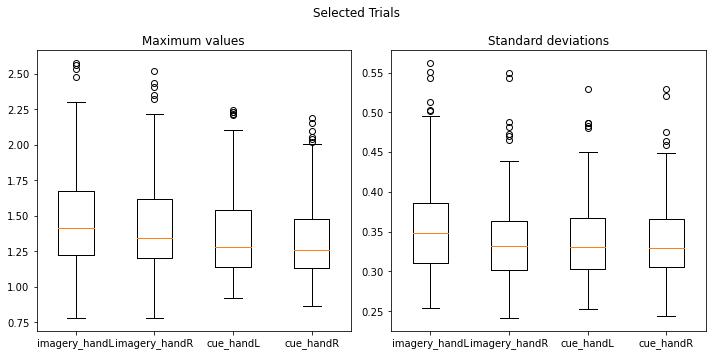

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Selected Trials')

axs[0].set_title('Maximum values')
axs[0].boxplot([ good_trials[cl].max(axis = (0,1)) for cl in classes ], labels=classes)

axs[1].set_title('Standard deviations')
axs[1].boxplot([ good_trials[cl].std(axis = (0,1)) for cl in classes ], labels=classes)

plt.tight_layout()
plt.show()

# Combine MI trials

If you want to classify idle/MI this is useful

In [50]:
good_trials['mi'] = np.concatenate([
    good_trials['imagery_handL'][:,:,:],
    good_trials['imagery_handR'][:,:,:]
], axis=2)

print(good_trials['mi'].shape)

(8, 500, 377)


# Combine Idle Trials

If you are classifying idle/left/right only take half of the idle data so that the dataset is balanced.

In [51]:
# good_trials['idle'] = np.concatenate([
#     good_trials['cue_handL'][:,:,-90:],
#     good_trials['cue_handR'][:,:,-90:]
# ], axis=2)

good_trials['idle'] = np.concatenate([
    good_trials['cue_handL'][:,:,:],
    good_trials['cue_handR'][:,:,:]
], axis=2)


print(good_trials['idle'].shape)

(8, 375, 381)


# Analysis

In [95]:
# ----------------------------------------------------------------
# H-PARAMS
# ----------------------------------------------------------------
classes = ['imagery_handL', 'imagery_handR']
# classes = ['imagery_handL', 'imagery_handR', 'idle']
# classes = ['idle', 'mi']
nfolds = 5
nclasses = len(classes)
band = [8, 16]
channels = [1,3,4,5, 6, 7]
nchannels = len(channels)
classifier = skLDA()
# ----------------------------------------------------------------

# Print some information
print('Classes:', classes)
print('Shape of EEG:', EEG.shape)
print('Sample rate:', fs)
print('Number of channels:', nchannels)
print('Frequency band for bandpower:', band)

Classes: ['imagery_handL', 'imagery_handR']
Shape of EEG: (8, 1023780)
Sample rate: 250
Number of channels: 6
Frequency band for bandpower: [8, 16]


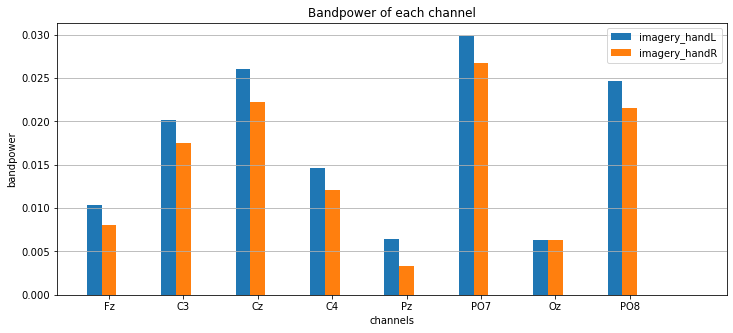

In [96]:
trials_bp = {}
for cl in classes:
    freqs, bandpower = analysis.bandpower(good_trials[cl], fs, band=band)
    trials_bp[cl] = bandpower

analysis.plot_bandpower(trials_bp, classes)

In [106]:
np.arange(1,nchannels)*2.0-0.4

array([ 1.6,  3.6,  5.6,  7.6,  9.6, 11.6, 13.6])

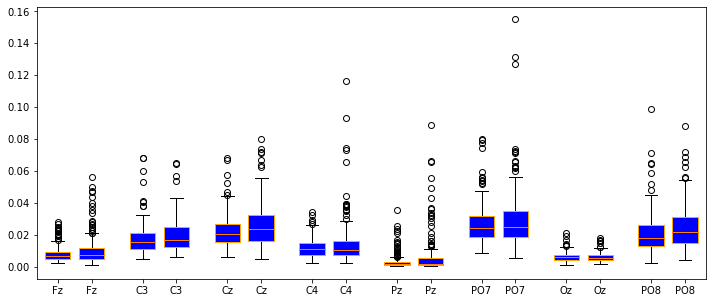

In [120]:
nchannels = trials[classes[0]].shape[0]

plt.figure(figsize=(12,5))
for i, cl in enumerate(classes):
    plt.boxplot(
        [trials_bp[cl][ch,:] for ch in range(nchannels)],
        positions=np.arange(0,nchannels)*nclasses-i*0.8,
        widths=0.6,
        patch_artist=True,
        boxprops=dict(facecolor='b', color='orange'),
        labels=['Fz', 'C3', 'Cz', 'C4', 'Pz', 'PO7', 'Oz', 'PO8']
    )

## LDA

In [92]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as skLDA
from sklearn.metrics import confusion_matrix

In [93]:
# Find size of cross val datasets
test_set_shapes = {}
train_set_shapes = {}
for cl in classes:
    test_set_shapes[cl] = int(good_trials[cl].shape[2] / nfolds)
    train_set_shapes[cl] = good_trials[cl].shape[2] - test_set_shapes[cl]


# Places to plot/view the results
accuracies = {}
class_accuracies = {}
confusion_matrices = {}

# Run cross validation for k folds
for i in range(nfolds):    
    train = {}
    test = {}
    for cl in classes:
        ntest = test_set_shapes[cl]
        train[cl] = np.concatenate(
            [good_trials[cl][:,:,:i*ntest], 
            good_trials[cl][:,:,(i+1)*ntest:]], axis=2)
        test[cl] = good_trials[cl][:,:,i*ntest:(i+1)*ntest]

    # Bandpower
    for cl in classes:
        _, bandpower = analysis.bandpower(train[cl], fs, band)
        train[cl] = bandpower[channels,:]
        _, bandpower = analysis.bandpower(test[cl], fs, band)
        test[cl] = bandpower[channels,:]
    
    # Build sk-learn compatible matrices
    X_train = np.empty([nchannels,0])
    y_train = np.array([])
    X_test = np.empty([nchannels,0])
    y_test = np.array([])
    for cl in classes:
        X_train = np.concatenate([X_train, train[cl]], axis=1)
        y_train = np.concatenate([y_train, np.ones(train[cl].shape[1]) * label2code[cl]], axis=0)
        X_test = np.concatenate([X_test, test[cl]], axis=1)
        y_test = np.concatenate([y_test, np.ones(test[cl].shape[1]) * label2code[cl]], axis=0)
    
    X_train =  X_train.T
    X_test =  X_test.T
    
    # LDA classifier
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)

    confusion_matrices[i] = confusion_matrix(y_test, y_pred)
    accuracies[i] = np.sum(y_pred == y_test) / y_pred.size
    class_accuracies[i] = {}
    for cl in classes:
        class_accuracies[i][cl] = np.sum(
            np.logical_and(y_pred == y_test, y_pred == label2code[cl])) / np.sum(y_test == label2code[cl]) 
    

In [94]:
av_class_accuracy = {}
for i in range(nfolds):
    for cl in classes:
        if cl in av_class_accuracy:
            av_class_accuracy[cl] += class_accuracies[i][cl]
        else:
            av_class_accuracy[cl] = class_accuracies[i][cl]

for k,v in av_class_accuracy.items():
    av_class_accuracy[k] = v/nfolds

print(channels, band)
print(av_class_accuracy)

[0, 1, 2, 3, 4, 5, 6, 7] [8, 16]
{'imagery_handL': 0.3783783783783784, 'imagery_handR': 0.6736842105263158}
